In [17]:
from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #DDE6D5; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E5C1CD; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #E8F3FF; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
''')

In [205]:
import warnings
warnings.filterwarnings('ignore')

In [215]:
import pandas as pd
import country_converter as coco
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import plotly.express as px

# Cleaning

## Original Dataset Cleaning

In [322]:
#load inital dataset
raw = pd.read_csv("life-expectancy.csv")

In [360]:
#define entity categories
continent = ['Africa', 'Asia', 'Europe', 'Americas', 'Oceania']
income_groups = ['High-income countries', 'Upper-middle-income countries', 'Middle-income countries', 'Lower-middle-income countries', 'Low-income countries', 'No income group available']
development = ['More developed regions', 'Small Island Developing States (SIDS)', 'Less developed regions', 'Less developed regions, excluding China', 'Less developed regions, excluding least developed countries', 'Least developed countries', 'Land-locked Developing Countries (LLDC)']

In [362]:
#create new df for continents, income level, development status
continents = raw[raw['Entity'].isin(continent) == True]
income = raw[raw['Entity'].isin(income_groups) == True]
develop = raw[raw['Entity'].isin(development) == True]

In [38]:
#create new df for countries
countries = raw[raw['Entity'].isin(development) == False]
countries = countries[countries['Entity'].isin(income_groups) == False]
countries = countries[countries['Entity'].isin(continent) == False]

In [55]:
#add continent column for countries df
converter = coco.CountryConverter()
countries['Continent'] = converter.convert(names=countries['Code'], src="ISO3", to="continent")

nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not found in ISO3
nan not fo

In [58]:
#find countries without continent match
a = countries[countries['Code'].isna() == True]
a = a[['Entity', 'Code']]
grouped = a.groupby(by="Entity").sum()

In [60]:
#update continent column
countries['Continent'] = countries['Continent'].str.replace('not found', 'Europe')

## Additional Datasets

### Disease Mortality Rates (2010 - 2021)

In [54]:
# load dataset (https://ghdx.healthdata.org/record/ihme-data/gbd-2021-cause-specific-mortality-1990-2021)
disease = pd.read_excel("disease-mortality-rates.XLSX")

In [63]:
#create a subset with only mortality rate per 100,000 people
disease = disease[['location_type', 'location_name', 'cause_name', '2010 (ASMR)', '2019 (ASMR)', '2020 (ASMR)', '2021 (ASMR)']]

#convert columns to numeric
cols = ['2010 (ASMR)', '2019 (ASMR)', '2020 (ASMR)', '2021 (ASMR)']
for i in cols:
    disease[i] = disease.loc[:, i].str.replace(r"\(.*\)","", regex=True)
    disease[i] = pd.to_numeric(disease.loc[:, i])

In [108]:
#create column for change from 2010 to 2021
disease.loc[:, 'change'] = (disease.loc[:, '2021 (ASMR)'] - disease.loc[:, '2010 (ASMR)'])

In [106]:
#create global dataset
globe = disease[disease['location_type'] == 'Global']

#create global grouped dataset by cause
globe_group = globe[['cause_name', '2010 (ASMR)', '2019 (ASMR)', '2020 (ASMR)', '2021 (ASMR)', 'change']].groupby(by='cause_name').mean().reset_index()

In [69]:
#create africa dataset
a = ['North Africa and Middle East', 'Central Sub-Saharan Africa', 'Eastern Sub-Saharan Africa', 'Southern Sub-Saharan Africa', 'Western Sub-Saharan Africa']
africa = disease[(disease['location_type'] == 'Region') & (disease['location_name'].isin(a) == True)]

#create grouped africa dataset by cause
ac = africa.copy()
ac = ac[['cause_name', '2010 (ASMR)', '2019 (ASMR)', '2020 (ASMR)', '2021 (ASMR)', 'change']]
africa_group = ac.groupby(by='cause_name').mean().reset_index()

In [103]:
#create column of difference between african vs global average in 2021
africa_group['diff'] = (africa_group['2021 (ASMR)'] - globe_group['2021 (ASMR)'])
africa_group = africa_group.sort_values(by='diff', ascending=False)

### Life Expectancy Decomposition (1990 - 2021)

In [344]:
#load dataset (https://cloud.ihme.washington.edu/s/6w3TkFaQw63Djnd?)
decomp = pd.read_excel("life-expectancy-decomp.XLSX")

#create africa df
af = ['Western Sub-Saharan Africa', 'North Africa and Middle East', 'Central Sub-Saharan Africa', 'Southern Sub-Saharan Africa', 'Eastern Sub-Saharan Africa']
decomp_africa = decomp[decomp['Location Name'].isin(af) == True]

#filter 1990-2021 only
decomp_africa = decomp_africa[(decomp_africa['Start Year'] == 1990) & (decomp_africa['End Year'] == 2021)]
decomp_africa = decomp_africa.drop(axis=0, index=670)

### Death in Armed Conflicts (1989-2022)

In [187]:
#load df (Uppsala Conflict Data Program (2023); Natural Earth (2022) – processed by Our World in Data)
conflict = pd.read_csv("deaths-in-armed-conflicts.csv")

In [93]:
#add continent column to df
converter = coco.CountryConverter()
conflicts['Continent'] = converter.convert(names=conflicts['Code'], src="ISO3", to="continent")

OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_ABK not found in ISO3
OWID_CZS not found in ISO3
OWID_CZS not found in ISO3
OWID_CZS not found in ISO3
O

In [94]:
#check for missed countries
# conflicts['Continent'].unique()

array(['not found', 'Asia', 'Europe', 'Africa', 'America', 'Oceania'],
      dtype=object)

In [97]:
#remove non-states/former states from df
# conflicts = conflicts[conflicts['Continent'] != 'not found']

In [99]:
#create df for african conflicts
# africa = conflicts[conflicts['Continent'] == 'Africa']

### Healthcare Expenditure
World Health Organization - Global Health Observatory (2024) – processed by Our World in Data

In [353]:
gdp.columns

Index(['Country', 'GDP 2022', 'iso_a3'], dtype='object')

### GDP

In [251]:
gdp = pd.read_csv("gdp.csv")
gdp = gdp.dropna()
converter = coco.CountryConverter()
gdp['Code'] = converter.convert(names=gdp['Country '], to="ISO3")
gdp

Africa Eastern and Southern not found in regex
Africa Western and Central not found in regex
Arab World not found in regex
Caribbean small states not found in regex
Central Europe and the Baltics not found in regex
Early-demographic dividend not found in regex
East Asia & Pacific not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific (IDA & IBRD countries) not found in regex
Euro area not found in regex
Europe & Central Asia not found in regex
Europe & Central Asia ( not found in regex
Europe & Central Asia (IDA & IBRD countries) not found in regex
European Union not found in regex
Fragile and conflict affected situations not found in regex
Heavily indebted poor countries (HIPC) not found in regex
High income not found in regex
IBRD only not found in regex
IDA & IBRD total not found in regex
IDA blend not found in regex
IDA only not found in regex
IDA total not found in regex
Late-demographic dividend not found in regex
Latin America & Caribbean not found in re

,Country,GDP 2022,Code
0,Albania,1.891638e+10,ALB
1,Algeria,1.949984e+11,DZA
2,American Samoa,8.710000e+08,ASM
3,Andorra,3.352031e+09,AND
4,Angola,1.067828e+11,AGO
...,...,...,...
237,Sub-Saharan Africa,2.060531e+12,not found
238,Sub-Saharan Africa (excluding high income),2.058943e+12,not found
239,Sub-Saharan Africa (IDA & IBRD countries),2.060531e+12,not found
240,Upper middle income,3.011093e+13,not found


In [263]:
#check which ones were missed - only regions, all country codes found
gdp.columns = ['Country', 'GDP 2022', 'iso_a3']
gdp

,Country,GDP 2022,iso_a3
0,Albania,1.891638e+10,ALB
1,Algeria,1.949984e+11,DZA
2,American Samoa,8.710000e+08,ASM
3,Andorra,3.352031e+09,AND
4,Angola,1.067828e+11,AGO
...,...,...,...
237,Sub-Saharan Africa,2.060531e+12,not found
238,Sub-Saharan Africa (excluding high income),2.058943e+12,not found
239,Sub-Saharan Africa (IDA & IBRD countries),2.060531e+12,not found
240,Upper middle income,3.011093e+13,not found


# Introduction

1. To understand how Life Expectancy has developed, we will look at each continent's life expectancy over time.
    - **TODO: Line graph of life expectancy over time by continent with AVERAGE LINE**
2. We can see that Life Expectancy was fairly flat for all continents until 1870 (corresponding with Louis Pasteurs development of Germ Theory) where Europe, Oceania and the Americas begin their upward trend. However, for Asia and Africa, it is not until at least 1913 and 1925 respectively until they begin to rise. It should be noted that these figures are estimated, as data for Asia and Africa is very sparse until 1950, so it is difficult to find the exact point of change. Regardless, Africa begins showing signs of improvement at least 50 years after Germ Theory was developed.
3. This report aims to gain a deeper understanding of how Africa in particular was left behind in rising Life Expectancies, and what factors contribute to the continued gap between Africa and other continents.

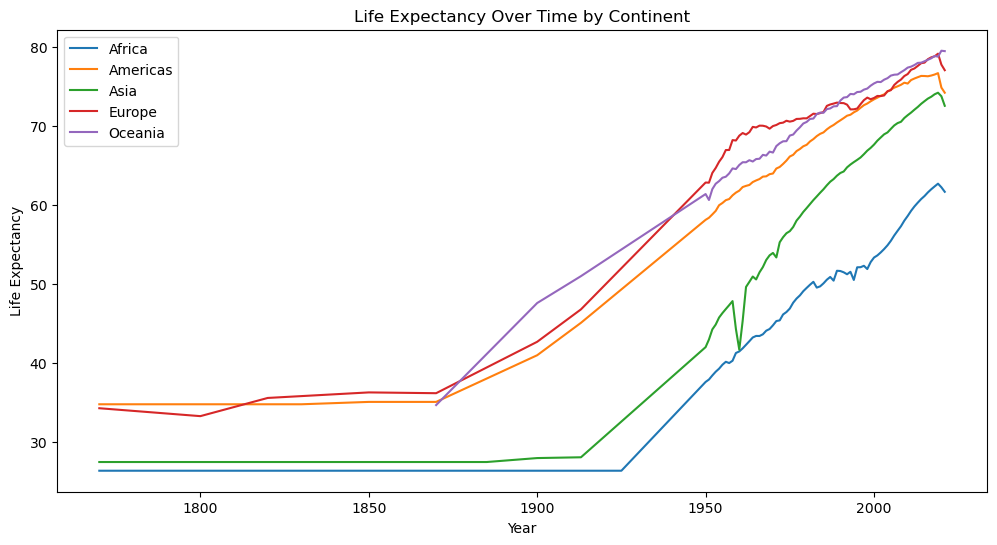

In [366]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=continents, x='Year', y='Period life expectancy at birth - Sex: all - Age: 0', hue='Entity')
plt.title('Life Expectancy Over Time by Continent')
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.legend()
plt.show()

# Historical Context

1. Africa was largely under colonial rule until the 1950's. Colonial management of the countries provided very little care to the Indigenous people, so the benefits of modern medicine were not distributed to the colonies. 
    - **TODO: Find a source**
2. In the 1950's the process of decolonisation begins. For some countries, Life Expectancy fluctuates greatly (e.g. Cameroon, South Sudan, Ethiopia) while others increase steadily (e.g. Botswana, Cape Verde, Mali). However, overall, the continent makes a significant increase in life expectancy by the end of this period.
    - **TODO: Side-by-Side Line graph of the life expectancy of (Cameroon, South Sudan, Ethiopia) and (Botswana, Cape Verde, Mali) from 1950-1975**
    - **TODO: Calculate pct change for these years (Africa vs Worldwide and compare)**
    - **TODO: Find sources on the decolonisation process of these countries**
3. The 1980's brought the 'Lost Decade', where living standards decreased overall, setting them back in Life Expectancy and the effects are seen well into the 1990's.
    - **TODO: Find a source**
    - **TODO: Reuse the plot from (Introduction), annotate / colour or something so that you can see the stagnation**

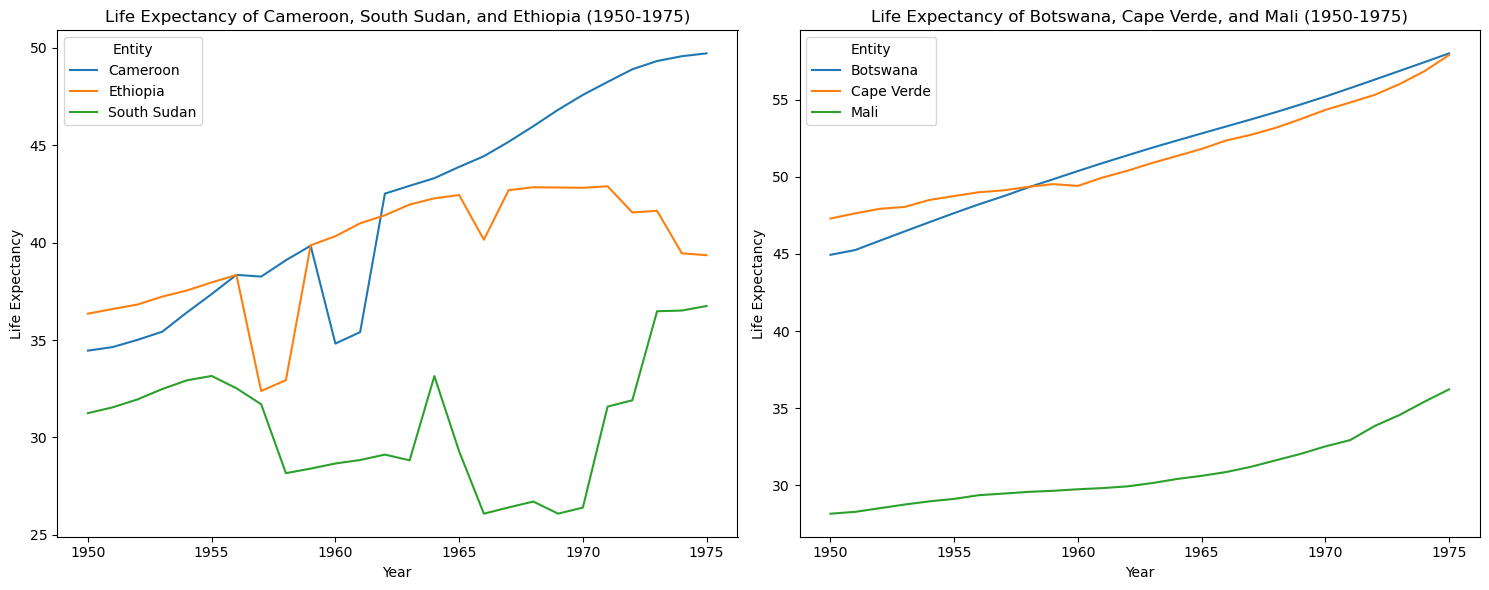

In [209]:
# Filter the data for the selected countries and time period
fluctuate = countries[(countries['Entity'].isin(['Cameroon', 'South Sudan', 'Ethiopia'])) & (countries['Year'] >= 1950) & (countries['Year'] <= 1975)]
smooth = countries[(countries['Entity'].isin(['Botswana', 'Cape Verde', 'Mali'])) & (countries['Year'] >= 1950) & (countries['Year'] <= 1975)]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first line graph
sns.lineplot(data=fluctuate, x='Year', y='Period life expectancy at birth - Sex: all - Age: 0', hue='Entity', ax=axes[0])
axes[0].set_title('Life Expectancy of Cameroon, South Sudan, and Ethiopia (1950-1975)')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Life Expectancy')

# Plot the second line graph
sns.lineplot(data=smooth, x='Year', y='Period life expectancy at birth - Sex: all - Age: 0', hue='Entity', ax=axes[1])
axes[1].set_title('Life Expectancy of Botswana, Cape Verde, and Mali (1950-1975)')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Life Expectancy')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [392]:
import pandas as pd
# Filter data for the years 1950 and 1975
continents_1950 = continents[continents['Year'] == 1950]
continents_1975 = continents[continents['Year'] == 1975]

# Calculate the percentage change for each continent
result = []
for continent in continents['Entity'].unique():
  life_expectancy_1950 = continents_1950[continents_1950['Entity'] == continent]['Period life expectancy at birth - Sex: all - Age: 0'].values[0]
  life_expectancy_1975 = continents_1975[continents_1975['Entity'] == continent]['Period life expectancy at birth - Sex: all - Age: 0'].values[0]
  percentage_change = ((life_expectancy_1975 - life_expectancy_1950) / life_expectancy_1950) * 100
  result.append({'Continent': continent, 'Percentage Change': percentage_change})

# Display the results in a DataFrame
pd.DataFrame(result).sort_values(by='Percentage Change', ascending=False)

,Continent,Percentage Change
2,Asia,34.887683
0,Africa,24.664106
1,Americas,13.775589
3,Europe,12.252144
4,Oceania,12.049237


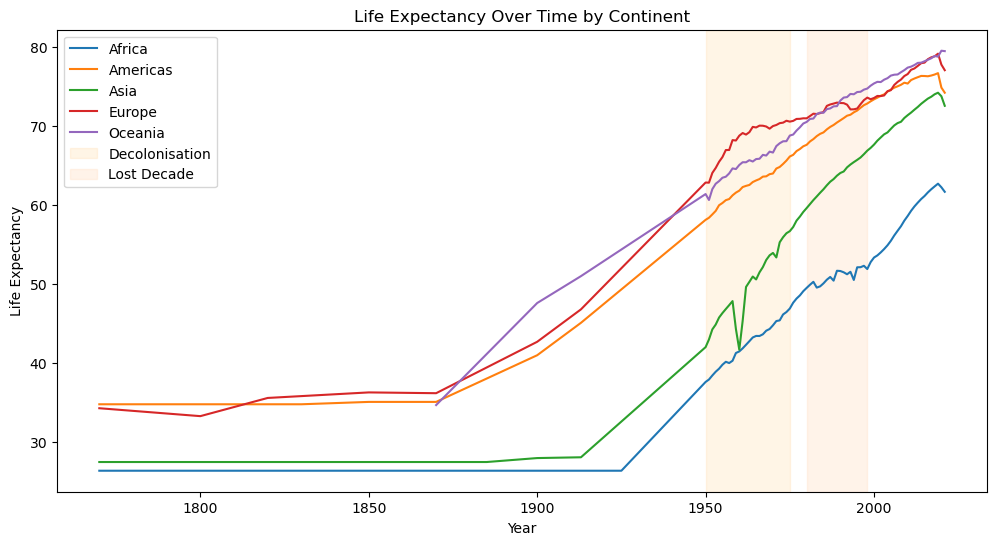

In [390]:
#plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=continents, x='Year', y='Period life expectancy at birth - Sex: all - Age: 0', hue='Entity')

#highlight the years 1980-1998 and 1950-1975
plt.axvspan(1950, 1975, color='navajowhite', alpha=0.3, label='Decolonisation')
plt.axvspan(1980, 1998, color='peachpuff', alpha=0.3, label='Lost Decade')

plt.title('Life Expectancy Over Time by Continent')
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.legend()
plt.show()

In [185]:
# filter data for the years 1980 and 1998
continents_1980 = continents[continents['Year'] == 1980]
continents_1998 = continents[continents['Year'] == 1998]

# calculate the percentage change for each continent
result = []
for continent in continents['Entity'].unique():
  life_expectancy_1980 = continents_1980[continents_1980['Entity'] == continent]['Period life expectancy at birth - Sex: all - Age: 0'].values[0]
  life_expectancy_1998 = continents_1998[continents_1998['Entity'] == continent]['Period life expectancy at birth - Sex: all - Age: 0'].values[0]
  percentage_change = ((life_expectancy_1998 - life_expectancy_1980) / life_expectancy_1980) * 100
  result.append({'Continent': continent, 'Percentage Change': percentage_change})
    
# display the results in a df
pd.DataFrame(result).sort_values(by='Percentage Change', ascending=False)


,Continent,Percentage Change
2,Asia,12.178733
4,Latin America and the Caribbean,11.140971
1,Americas,7.723928
6,Oceania,5.986728
0,Africa,4.816649
5,Northern America,4.079115
3,Europe,3.696176


# The Current Gap

## Context

1. Comparative GDP
    - **TODO: Map Visualisation**
2. Comparative Deaths in combat
    - **TODO: Map Visualisation**
    - **TODO (maybe): Correlation between war vs life expectancy is not consistent predictor but can impact (Rwandan Genocide)**
3. Comparative Health Expenditure
    - **TODO: Map Visualisation**

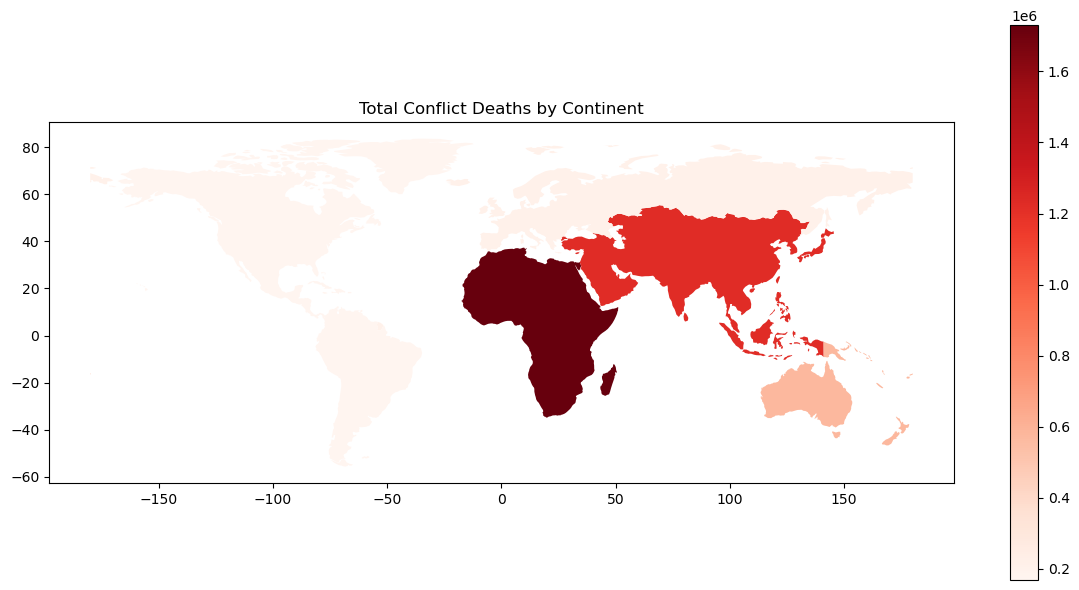

In [351]:
#world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#update total deaths per continent (match data continents with gpd continents)
conflict_continents = conflict.groupby('Entity')['Deaths in ongoing conflicts (best estimate) - Conflict type: all'].sum().reset_index()
na = {'Entity': 'North America', 'Deaths in ongoing conflicts (best estimate) - Conflict type: all': 168048}
sa = {'Entity': 'South America', 'Deaths in ongoing conflicts (best estimate) - Conflict type: all': 168048}
a = {'Entity': 'Asia', 'Deaths in ongoing conflicts (best estimate) - Conflict type: all': 571516 + 653621}
o = {'Entity': 'Oceania', 'Deaths in ongoing conflicts (best estimate) - Conflict type: all': 571516}
conflict_continents.loc[6] = na
conflict_continents.loc[7] = sa
conflict_continents.loc[8] = a
conflict_continents.loc[9] = o
conflict_continents = conflict_continents[conflict_continents['Entity'].isin(world['continent'].unique()) == True]

#update geodf for continents
continent_data = {
    'Continent': ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'],
    'geometry': [
        world[world['continent'] == 'Africa']['geometry'].unary_union,
        world[world['continent'] == 'Asia']['geometry'].unary_union,
        world[world['continent'] == 'Europe']['geometry'].unary_union,
        world[world['continent'] == 'North America']['geometry'].unary_union,
        world[world['continent'] == 'Oceania']['geometry'].unary_union,
        world[world['continent'] == 'South America']['geometry'].unary_union
    ]
}
continent_gdf = gpd.GeoDataFrame(continent_data, crs=world.crs)


conflict_continents.columns = ['Continent', 'Deaths in ongoing conflicts (best estimate) - Conflict type: all']

#merge
continent_conflicts = continent_gdf.merge(conflict_continents, on='Continent', how='left')

#plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
continent_conflicts.plot(column='Deaths in ongoing conflicts (best estimate) - Conflict type: all', cmap='Reds', legend=True, ax=ax, missing_kwds={'color': 'lightgrey'})
ax.set_title('Total Conflict Deaths by Continent')
plt.tight_layout()
plt.show()


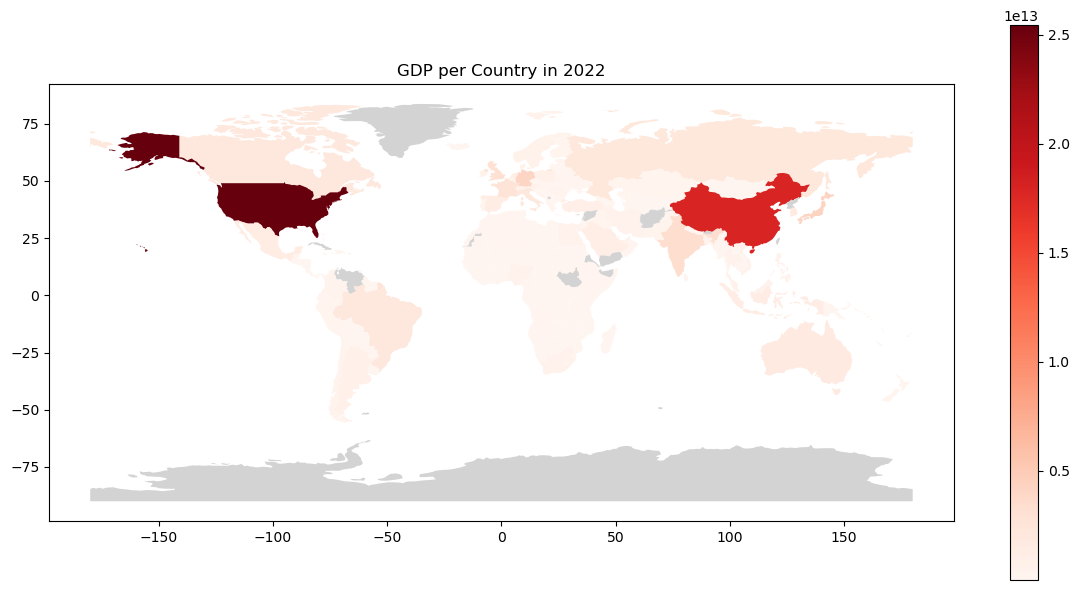

In [265]:
#world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#merge
world_gdp = world.merge(gdp, left_on='iso_a3', right_on='iso_a3', how='left')

#plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
world_gdp.plot(column='GDP 2022', cmap='Reds', legend=True, ax=ax, missing_kwds={'color': 'lightgrey'})
ax.set_title('GDP per Country in 2022')
plt.tight_layout()
plt.show()


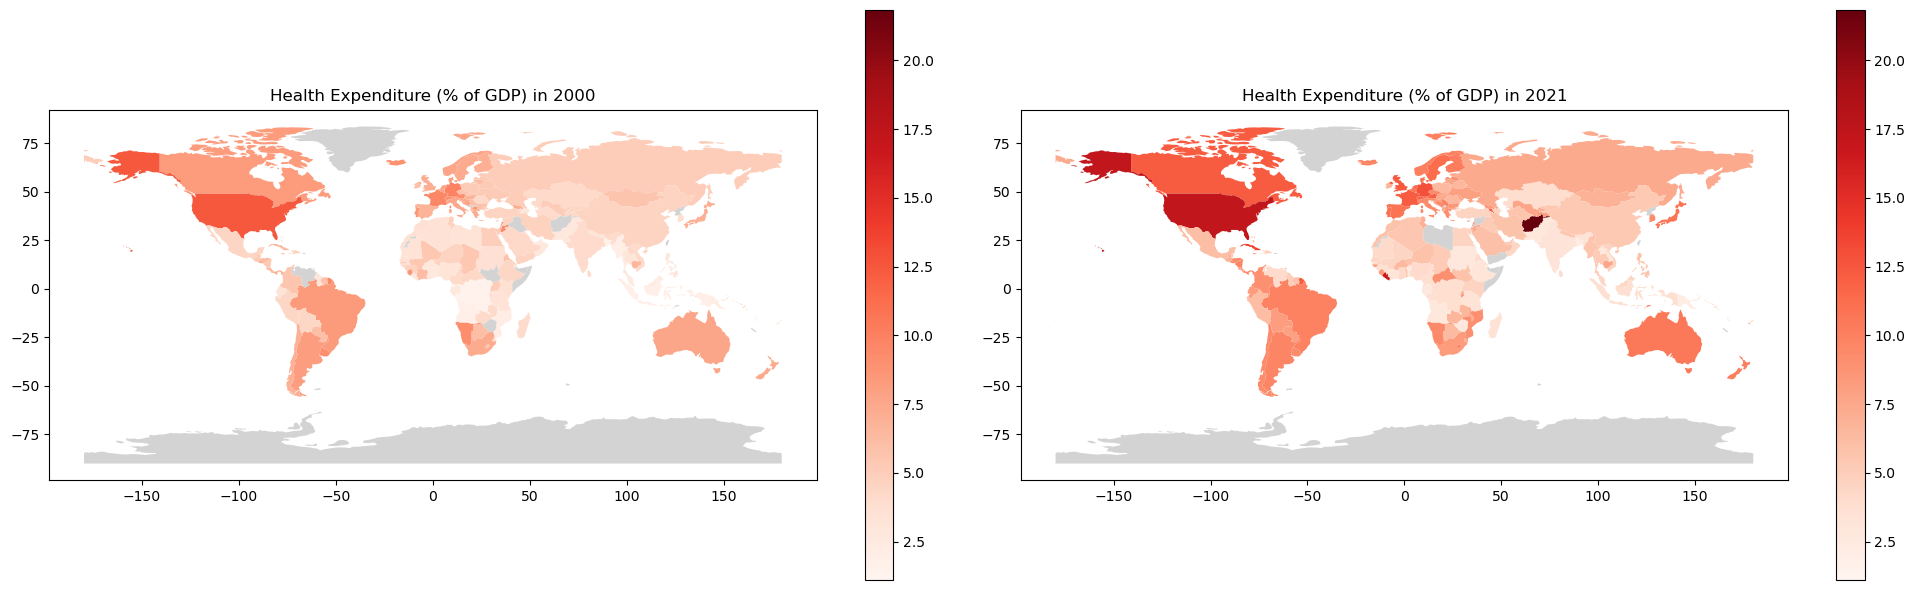

In [458]:
#world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#get data for 2000 and 2021
expense_2000 = expense[['Country Code', '2000']].dropna()
expense_2021 = expense[['Country Code', '2021']].dropna()

#merge
world_expense_2000 = world.merge(expense_2000, left_on='iso_a3', right_on='Country Code', how='left')
world_expense_2021 = world.merge(expense_2021, left_on='iso_a3', right_on='Country Code', how='left')

#subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

#match scales
vmin = min(world_expense_2000['2000'].min(), world_expense_2021['2021'].min())
vmax = max(world_expense_2000['2000'].max(), world_expense_2021['2021'].max())

#plotting 2000
world_expense_2000.plot(column='2000', cmap='Reds', legend=True, ax=axes[0], missing_kwds={'color': 'lightgrey'}, vmin=vmin, vmax=vmax)
axes[0].set_title('Health Expenditure (% of GDP) in 2000')

#plotting 2021
world_expense_2021.plot(column='2021', cmap='Reds', legend=True, ax=axes[1], missing_kwds={'color': 'lightgrey'}, vmin=vmin, vmax=vmax)
axes[1].set_title('Health Expenditure (% of GDP) in 2021')

#layout
plt.tight_layout()
plt.show()


## Disease Analysis

1. Africa leads in mortality rate in a lot of different diseases.
    - **TODO: Treemap of difference in mortality rates with colour differences for negative values.**
2. Diseases with the highest impact on Africa's Life Expectancy
    - **TODO: Side-by-Side Graphs of Disease Impacts on Life Expectancy by year (1990-2021)**
    - **TODO: Side-by-Side Comparative graphs of mortality rates of most impactful diseases in Africa vs Global Average**
3. While Africa generally has higher mortality rates for many diseases, its Life Expectancy is most vulnerable to pandemics (HIV, COVID-19) - their response is much slower compared to other countries. Likely factors are the above metrics of GDP, Health Expenditure and Unrest.

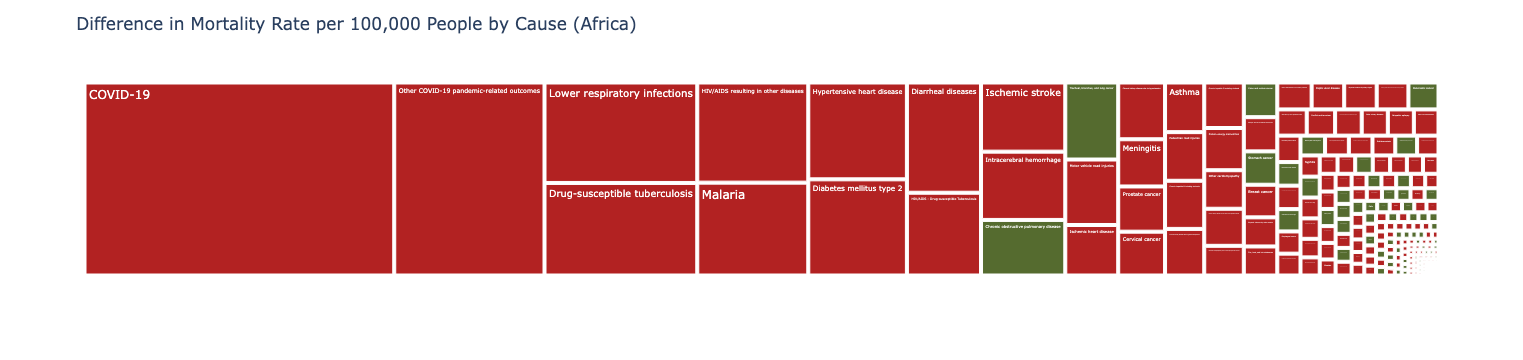

In [424]:
#negatives
africa_group['diff_abs'] = africa_group['diff'].abs()
africa_group['color'] = np.where(africa_group['diff'] < 0, 'Negative', 'Positive')

#plotting
fig = px.treemap(africa_group, path=['cause_name'], values='diff_abs', color='color',
                 color_discrete_map={'Positive':'firebrick', 'Negative':'darkolivegreen'},
                 hover_data={'cause_name': True, 'diff_abs': True})  # Include hover data

#fix tooltips
fig.update_traces(hovertemplate='<b>Mortality Cause: %{customdata[0]}</b><br>Difference from Global Mortality Rate: %{customdata[1]:.2f}')

fig.update_layout(title='Difference in Mortality Rate per 100,000 People by Cause (Africa)')
fig.show()

In [444]:
#calculate percent of causes where africa has a higher mortality rate than the global average
pos = len(africa_group[africa_group['color'] == 'Positive'])
neg = len(africa_group[africa_group['color'] != 'Positive'])
pos_pct = round((pos/(pos + neg))*100, 0)
print(pos+neg)

230


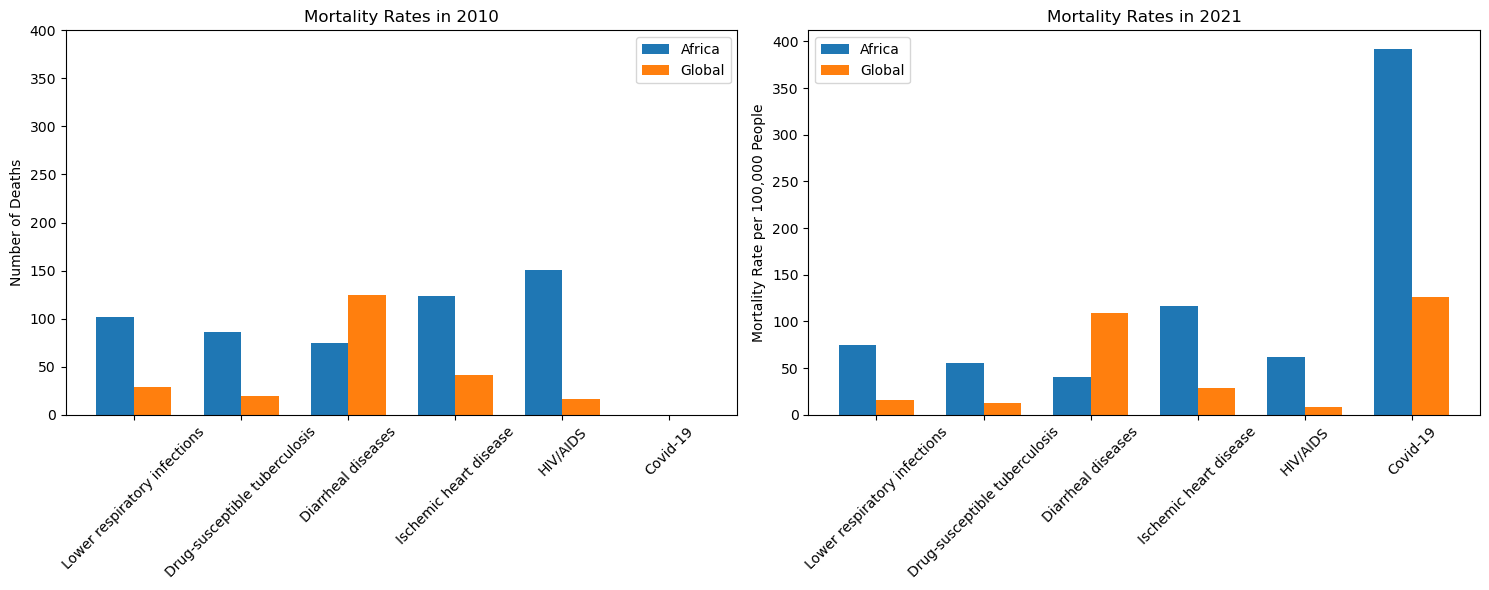

In [456]:
#grouping together different categories of disease
hiv = ['HIV/AIDS - Drug-susceptible Tuberculosis', 'HIV/AIDS - Extensively drug-resistant Tuberculosis', 'HIV/AIDS - Multidrug-resistant Tuberculosis without extensive drug resistance', 'HIV/AIDS resulting in other diseases', 'Maternal deaths aggravated by HIV/AIDS']
covid = ['COVID-19', 'Other COVID-19 pandemic-related outcomes']

a_hiv_df = africa_group[africa_group['cause_name'].isin(hiv)]
a_covid_df = africa_group[africa_group['cause_name'].isin(covid)]

g_hiv_df = globe_group[globe_group['cause_name'].isin(hiv)]
g_covid_df = globe_group[globe_group['cause_name'].isin(covid)]

#add to main dfs
a_hiv = {'cause_name': 'HIV/AIDS', '2010 (ASMR)': a_hiv_df['2010 (ASMR)'].sum(), '2019 (ASMR)': a_hiv_df['2019 (ASMR)'].sum(), '2020 (ASMR)': a_hiv_df['2020 (ASMR)'].sum(), '2021 (ASMR)': a_hiv_df['2021 (ASMR)'].sum()}
a_covid = {'cause_name': 'Covid-19', '2010 (ASMR)': a_covid_df['2010 (ASMR)'].sum(), '2019 (ASMR)': a_covid_df['2019 (ASMR)'].sum(), '2020 (ASMR)': a_covid_df['2020 (ASMR)'].sum(), '2021 (ASMR)': a_covid_df['2021 (ASMR)'].sum()}
g_hiv = {'cause_name': 'HIV/AIDS', '2010 (ASMR)': g_hiv_df['2010 (ASMR)'].sum(), '2019 (ASMR)': g_hiv_df['2019 (ASMR)'].sum(), '2020 (ASMR)': g_hiv_df['2020 (ASMR)'].sum(), '2021 (ASMR)': g_hiv_df['2021 (ASMR)'].sum()}
g_covid = {'cause_name': 'Covid-19', '2010 (ASMR)': g_covid_df['2010 (ASMR)'].sum(), '2019 (ASMR)': g_covid_df['2019 (ASMR)'].sum(), '2020 (ASMR)': g_covid_df['2020 (ASMR)'].sum(), '2021 (ASMR)': g_covid_df['2021 (ASMR)'].sum()}

africa_group.loc[231] = a_hiv
africa_group.loc[232] = a_covid
globe_group.loc[231] = g_hiv
globe_group.loc[232] = g_covid

top_causes = ['HIV/AIDS', 'Covid-19', 'Ischemic heart disease', 'Lower respiratory infections', 'Drug-susceptible tuberculosis', 'Diarrheal diseases']

#filter for 2010 and 2021
africa_2010 = africa_group[africa_group['cause_name'].isin(top_causes)]
global_2010 = globe_group[globe_group['cause_name'].isin(top_causes)]
africa_2021 = africa_group[africa_group['cause_name'].isin(top_causes)]
global_2021 = globe_group[globe_group['cause_name'].isin(top_causes)]                                                       
                                                            
#subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

#plotting for 2010
bar_width = 0.35
index = np.arange(len(africa_2010['cause_name']))
axes[0].bar(index, africa_2010['2010 (ASMR)'], bar_width, label='Africa')
axes[0].bar(index + bar_width, global_2010['2010 (ASMR)'], bar_width, label='Global')
axes[0].set_title('Mortality Rates in 2010')
axes[0].set_ylabel('Number of Deaths')
axes[0].set_ylim(0, 400)
axes[0].set_xticks(index + bar_width / 2)
axes[0].set_xticklabels(africa_2010['cause_name'], rotation=45)
axes[0].legend()

#plotting for 2021
axes[1].bar(index, africa_2021['2021 (ASMR)'], bar_width, label='Africa')
axes[1].bar(index + bar_width, global_2021['2021 (ASMR)'], bar_width, label='Global')
axes[1].set_title('Mortality Rates in 2021')
axes[1].set_ylabel('Mortality Rate per 100,000 People')
axes[1].set_xticks(index + bar_width / 2)
axes[1].set_xticklabels(africa_2021['cause_name'], rotation=45)
axes[1].legend()

#layout
plt.tight_layout()
plt.show()

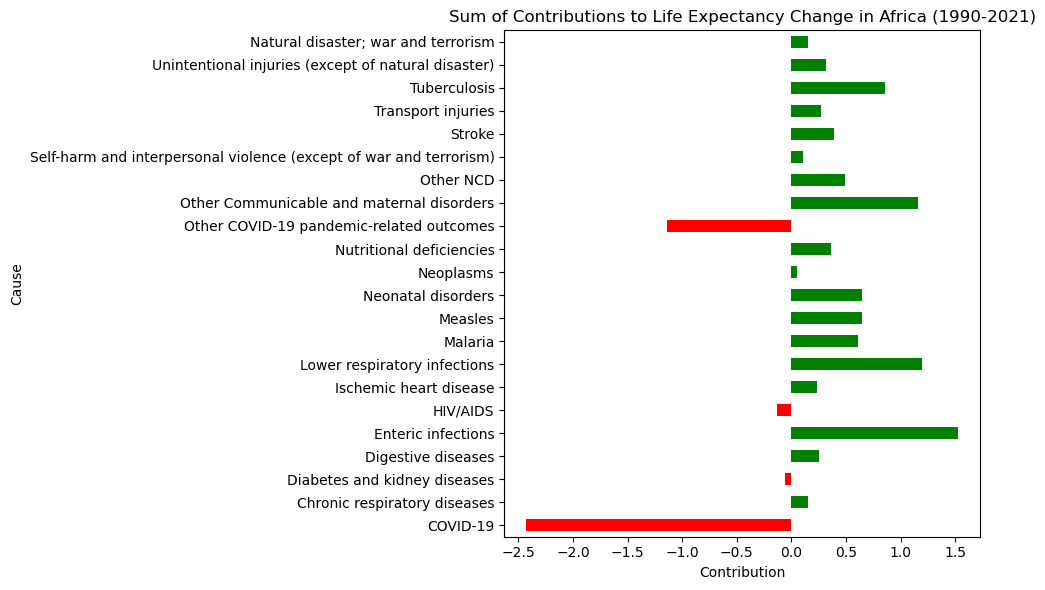

In [450]:
columns_to_avg = decomp_africa.columns[5:]
decomp_africa_avg = decomp_africa[columns_to_avg].mean()

#plotting
plt.figure(figsize=(10, 6))
colors = ['red' if v < 0 else 'green' for v in decomp_africa_sum.values]
decomp_africa_avg.plot(kind='barh', color=colors)
plt.title('Sum of Contributions to Life Expectancy Change in Africa (1990-2021)')
plt.ylabel('Cause')
plt.xlabel('Contribution')
plt.tight_layout()
plt.show()

# Potential Topics

## Specific Disease
*Can we explain the reason behind Africa's lagging life expectancy by some specific diseases?*
- *If Africa is being left behind on life expectancy growth, are there any specific diseases that can be accountable? Are they preventable - if it's not affecting other continents, they probably are.*
- *Has the Gates Foundation done much? (lol)*
- *Why did an extra 55 years to see the improved life expectancy outcomes following the discoveries of Louis Pasteur? Is a similar thing happening now?*

## War
*Can we explain a subset of countries life expectancy according to wars or political events like famines, etc and can we explain why the life expectancy will bounce back after these events? Additionally, will these political events have a longer term effect on population (e.g. maybe a country's life expectancy plummets due to a genocide, then the average life expectancy does bounce back but the population of the country will decrease. So the life expectancy may be high, but it is because it only includes the survivors.*
- *Does war have a significant effect on life expectancy from birth? Are there any countries that don't follow this upward trend?*

## How are Regions Left Behind?
- *We know that life expectancy has been going up for a long time, and the trend is found nearly everywhere. But, why is that Africa is still lagging way behind all other continents?*
- *Well, we can see that they had a much later start than every other continent - why?* **Records weren't really kept until 1950 when decolonisation really started. Colonialists weren't particularly interested in setting up medical infrastructure for the Indigenous people, and so they didn't get to feel the benefits of rapidly improving modern medicine until they started creating their own medical infrastructure.**
- *So what are the current effects? What diseases / causes of death are the most prevalent in Africa and why are they able to thrive where they have been eradicated in the rest of the world?* **TODO: look at life expectancy decomp + analyse the diseases that Africa is above average in**
- *Then they had the 'lost decade' - why did they fail to make it?*
- *We can also see, the biggest increase in deaths over time in Africa aside from Covid-19 (which they suffered the worst out of all continents) from **terrorism and conflict*** - *(this is led by Ethiopia/Somalia and the ethnic groups within)*
- *So we might want to think about how terrorism and conflict impacts life expectancy historically*
- *We might also want to think about how it affects overall population growth, and how that matches up with life expectancy*

## Storytelling

1. There is a trend of increasing life expectancy over time, fueled most clearly by the development of germ theory in 1870.
2. However, Africa does not start increasing until much later on - why?
    * Largely colonised, and colonial forces did not create much medical infrastructure for the Indigenous people, so the benefits of modern medicine were not shared. In the 50's, when decolonisation begins, then they start to develop these critical infrastructures.
    * So why are they still not meeting the global standard? Let's look into different diseases which are impacting the continent the most, comparative to other countries as well.
3. But disease is not the whole story, looking on a country level we can see the impact of conflict and terrorism in the region - focus on Sudan & Palestine
    * Can we find a correlation between deaths due to armed conflict and life expectancy?
    * Highlight how excessive conflict is in Africa comparative to other regions

**Pre 2000s / 90s**
1. There is a trend of increasing life expectancy over time, fueled most clearly by the development of germ theory in 1870.
2. However, Africa does not start increasing until much later on - why?
    a. Largely colonised, and colonial forces did not create much medical infrastructure for the Indigenous people, so the benefits of modern medicine were not shared. In the 50's, when decolonisation begins, then they start to develop these critical infrastructures.

**2000s Onward**

3. So why are they still not meeting the global standard? Let's look into different diseases which are impacting the continent the most, comparative to other countries as well.
4. But disease is not the whole story, looking on a country level we can see the impact of conflict and terrorism in the region - focus on Sudan & Palestine
    * Can we find a correlation between deaths due to armed conflict and life expectancy?
    * Highlight how excessive conflict is in Africa comparative to other regions

## TODO

### Analysis
- Create line graph of life expectancy by continent over time, with annotations on 1870 to mark the start of the upward trend and on 1935 to show when Africa begins to rise.
- Find a source (best would be a dataset) explaining medical infrastructure in colonial times / when health outcomes began to improve
- Disease analysis: point to specific diseases that are holding Africa back and their development over time (HIV, COVID-19, etc)
- Year on year change in life expectancy with year on year combat deaths - looking for correlation (time series analysis research)
- Case study on South Sudan 
- Map visualisation of combat deaths by continent (or country?)

### Report
- Convert to RMD
- Data provenance